The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.2
!pip install -U mxnet-cu101==1.7.0


# Image Augmentation
:label:`sec_image_augmentation`

In :numref:`sec_alexnet`, 
we mentioned that large datasets 
are a prerequisite
for the success of
deep neural networks
in various applications.
*Image augmentation* 
generates similar but distinct training examples
after a series of random changes to the training images, thereby expanding the size of the training set.
Alternatively,
image augmentation can be motivated
by the fact that 
random tweaks of training examples 
allow models to less rely on
certain attributes, thereby improving their generalization ability.
For example, we can crop an image in different ways to make the object of interest appear in different positions, thereby reducing the dependence of a model on the position of the object. 
We can also adjust factors such as brightness and color to reduce a model's sensitivity to color.
It is probably true
that image augmentation was indispensable
for the success of AlexNet at that time.
In this section we will discuss this widely used technique in computer vision.


In [1]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Common Image Augmentation Methods

In our investigation of common image augmentation methods, we will use the following $400\times 500$ image an example.


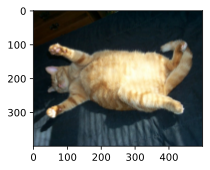

In [2]:
d2l.set_figsize()
img = image.imread('../img/cat1.jpg')
d2l.plt.imshow(img.asnumpy());

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, next we define an auxiliary function `apply`. This function runs the image augmentation method `aug` multiple times on the input image `img` and shows all the results.


In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### Flipping and Cropping


[**Flipping the image left and right**] usually does not change the category of the object. 
This is one of the earliest and most widely used methods of image augmentation.
Next, we use the `transforms` module to create the `RandomFlipLeftRight` instance, which flips
an image left and right with a 50% chance.


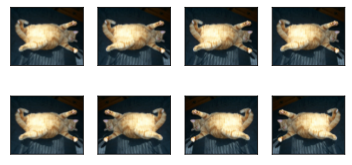

In [4]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

[**Flipping up and down**] is not as common as flipping left and right. But at least for this example image, flipping up and down does not hinder recognition.
Next, we create a `RandomFlipTopBottom` instance to flip
an image up and down with a 50% chance.


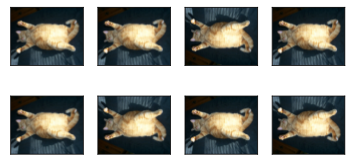

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

In the example image we used, the cat is in the middle of the image, but this may not be the case in general. 
In :numref:`sec_pooling`, we explained that the pooling layer can reduce the sensitivity of a convolutional layer to the target position.
In addition, we can also randomly crop the image to make objects appear in different positions in the image at different scales, which can also reduce the sensitivity of a model to the target position.

In the code below, we [**randomly crop**] an area with an area of $10\% \sim 100\%$ of the original area each time, and the ratio of width to height of this area is randomly selected from $0.5 \sim 2$. Then, the width and height of the region are both scaled to 200 pixels. 
Unless otherwise specified, the random number between $a$ and $b$ in this section refers to a continuous value obtained by random and uniform sampling from the interval $[a, b]$.


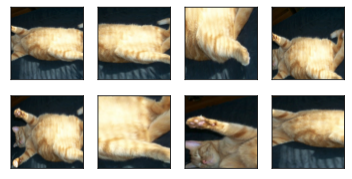

In [6]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Changing Colors

Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we [**randomly change the brightness**] of the image to a value between 50% ($1-0.5$) and 150% ($1+0.5$) of the original image.


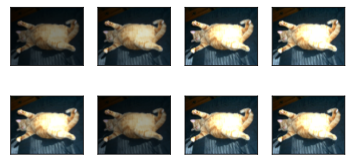

In [7]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

Similarly, we can [**randomly change the hue**] of the image.


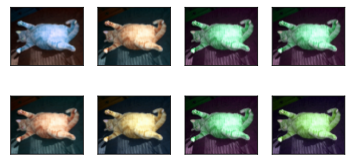

In [8]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

We can also create a `RandomColorJitter` instance and set how to [**randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time**].


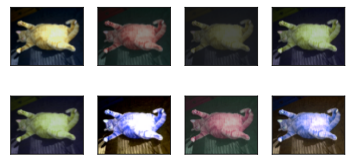

In [9]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### Combining Multiple Image Augmentation Methods

In practice, we will [**combine multiple image augmentation methods**]. 
For example,
we can combine the different image augmentation methods defined above and apply them to each image via a `Compose` instance.


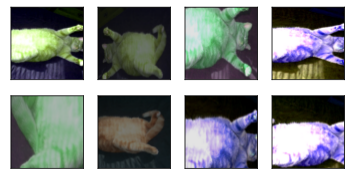

In [10]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## [**Training with Image Augmentation**]

Let us train a model with image augmentation.
Here we use the CIFAR-10 dataset instead of the Fashion-MNIST dataset that we used before. 
This is because the position and size of the objects in the Fashion-MNIST dataset have been normalized, while the color and size of the objects in the CIFAR-10 dataset have more significant differences. 
The first 32 training images in the CIFAR-10 dataset are shown below.


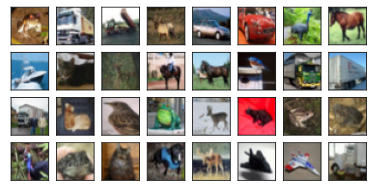

In [11]:
d2l.show_images(gluon.data.vision.CIFAR10(
    train=True)[0:32][0], 4, 8, scale=0.8);

In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during prediction. 
[**Here we only use the simplest random left-right flipping method**]. In addition, we use a `ToTensor` instance to convert a minibatch of images into the format required by the deep learning framework, i.e., 
32-bit floating point numbers between 0 and 1 with the shape of (batch size, number of channels, height, width).


In [12]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

Next, we define an auxiliary function to facilitate reading the image and
applying image augmentation. 
The `transform_first` function provided by Gluon's
datasets applies image augmentation to the first element of each training
example (image and label), i.e., the image. 
For
a detailed introduction to `DataLoader`, please refer to :numref:`sec_fashion_mnist`.


In [13]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

### Multi-GPU Training

We train the ResNet-18 model from
:numref:`sec_resnet` on the
CIFAR-10 dataset.
Recall the introduction to
multi-GPU training in :numref:`sec_multi_gpu_concise`.
In the following,
[**we define a function to train and evaluate the model using multiple GPUs**].


In [14]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, devices,
                     split_f=d2l.split_batch):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    X_shards, y_shards = split_f(features, labels, devices)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
              in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The `True` flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(d2l.accuracy(pred_shard, y_shard)
                        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [15]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus(), split_f=d2l.split_batch):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

Now we can [**define the `train_with_data_aug` function to train the model with image augmentation**].
This function gets all available GPUs, 
uses Adam as the optimization algorithm,
applies image augmentation to the training dataset,
and finally calls the `train_ch13` function just defined to train and evaluate the model.


In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Let us [**train the model**] using image augmentation based on random left-right flipping.


loss 0.173, train acc 0.940, test acc 0.835
4500.2 examples/sec on [gpu(0), gpu(1)]


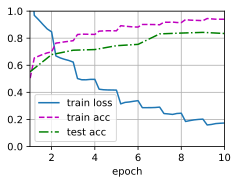

In [17]:
train_with_data_aug(train_augs, test_augs, net)

## Summary

* Image augmentation generates random images based on existing training data to improve the generalization ability of models.
* In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during prediction.
* Deep learning frameworks provide many different image augmentation methods, which can be applied simultaneously.


## Exercises

1. Train the model without using image augmentation: `train_with_data_aug(test_augs, test_augs)`. Compare training and testing accuracy when using and not using image augmentation. Can this comparative experiment support the argument that image augmentation can mitigate overfitting? Why?
1. Combine multiple different image augmentation methods in model training on the CIFAR-10 dataset. Does it improve test accuracy? 
1. Refer to the online documentation of the deep learning framework. What other image augmentation methods does it also provide?


[Discussions](https://discuss.d2l.ai/t/367)
